Phase 1: Uploading Data

In [10]:
from google.colab import files
import pandas as pd
import zipfile
import os

# Step 1: Upload the file (you've already done this, but let's put it here for completeness)
print("Please upload your 'IMDB Dataset.csv (1).zip' file:")
uploaded = files.upload()

# Get the exact name of the uploaded zip file
zip_file_name = list(uploaded.keys())[0] # This will get 'IMDB Dataset.csv (1).zip'

print(f"Uploaded file: {zip_file_name}")

# Step 2: Unzip the file
# Create a directory to extract to, if you want to keep things tidy
extract_dir = "imdb_data"
os.makedirs(extract_dir, exist_ok=True) # Creates the directory if it doesn't exist

print(f"Unzipping {zip_file_name} to {extract_dir}/...")
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir) # Extracts all contents to the specified directory

print("Unzipping complete.")

# Step 3: Find the CSV file within the unzipped directory
# Often, the CSV will be directly inside the zip, with the original name 'IMDB Dataset.csv'
# Let's list the contents of the extracted directory to be sure
extracted_files = os.listdir(extract_dir)
print(f"Files extracted to '{extract_dir}/': {extracted_files}")

# Assuming the CSV is named 'IMDB Dataset.csv' inside the zip, construct the full path
csv_file_path = os.path.join(extract_dir, 'IMDB Dataset.csv')

# Step 4: Load the CSV using its correct path
try:
    df = pd.read_csv(csv_file_path)
    print("\nCSV loaded successfully!")
    print(df.head())
    print(df.columns)
except FileNotFoundError:
    print(f"\nError: The CSV file 'IMDB Dataset.csv' was not found inside the zip at {csv_file_path}.")
    print("Please double-check the actual name of the CSV file inside your zip archive.")
    print("You might need to adjust 'IMDB Dataset.csv' in the `os.path.join` line.")
except Exception as e:
    print(f"\nAn unexpected error occurred while loading the CSV: {e}")

Please upload your 'IMDB Dataset.csv (1).zip' file:


Saving IMDB Dataset.csv.zip to IMDB Dataset.csv (2).zip
Uploaded file: IMDB Dataset.csv (2).zip
Unzipping IMDB Dataset.csv (2).zip to imdb_data/...
Unzipping complete.
Files extracted to 'imdb_data/': ['IMDB Dataset.csv']

CSV loaded successfully!
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Index(['review', 'sentiment'], dtype='object')


Phase 2: Initial inspection/conversion

In [11]:
# Prompt: Check the unique values in the 'sentiment' column and their counts.
# Also, convert the 'sentiment' column from text ('positive', 'negative') to numerical (1, 0).
print(df['sentiment'].value_counts())
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
print(df.head()) # Verify conversion

sentiment
positive    25000
negative    25000
Name: count, dtype: int64
                                              review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1


Data Preprocessing and Exploration
Idea 1: Splitting Data

In [12]:
# Prompt: Split the DataFrame into training and testing sets.
# Use 80% of the data for training and 20% for testing.
# Ensure the split is stratified based on the 'sentiment' column to maintain class balance.
# Use `sklearn.model_selection.train_test_split`.

from sklearn.model_selection import train_test_split

# X will be your features (reviews), y will be your target (sentiment)
X = df['review'].values
y = df['sentiment'].values

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # stratify=y is important for balanced datasets
)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (40000,)
Shape of y_train: (40000,)
Shape of X_test: (10000,)
Shape of y_test: (10000,)


Idea 2: Tokenization and Sequencing

In [13]:
# Prompt: Initialize a Tokenizer from TensorFlow Keras.
# Set `num_words` to 10000 (meaning we'll consider the top 10,000 most frequent words).
# Set `oov_token` to "<unk>" for out-of-vocabulary words.
# Fit the tokenizer *only* on the training reviews (`X_train`).
# Then, convert both training and testing reviews into sequences of integers.

from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<unk>")

# Fit tokenizer only on training data to prevent data leakage from test set
tokenizer.fit_on_texts(X_train)

# Convert text reviews to sequences of integers
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

print(f"Length of first training sequence (before padding): {len(train_sequences[0])}")
print(f"First few words of first training sequence: {train_sequences[0][:10]}")
print(f"Number of unique tokens found by tokenizer: {len(tokenizer.word_index)}")

Length of first training sequence (before padding): 165
First few words of first training sequence: [11, 1055, 12, 120, 1506, 458, 32, 1609, 143, 9]
Number of unique tokens found by tokenizer: 111959


Idea 3: Padding Sequences

In [14]:
# Prompt: Pad the training and testing sequences to a fixed maximum length.
# Choose a `max_len` (e.g., 256 or 500, depending on review length distribution - you can explore this first if you want).
# Use `padding='post'` and `truncating='post'`.
# Convert the padded sequences to NumPy arrays.

from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np # Ensure numpy is imported if not already

max_len = 256 # A common choice for movie reviews

train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

# Ensure labels are also numpy arrays for Keras
y_train = np.array(y_train)
y_test = np.array(y_test)


print(f"Shape of train_padded after padding: {train_padded.shape}")
print(f"Shape of test_padded after padding: {test_padded.shape}")
print(f"First padded training sequence (first 10 elements): {train_padded[0][:10]}")

Shape of train_padded after padding: (40000, 256)
Shape of test_padded after padding: (10000, 256)
First padded training sequence (first 10 elements): [  11 1055   12  120 1506  458   32 1609  143    9]


Phase 3 - Model Building and Training

In [17]:
# Prompt: Define a simple deep learning model for binary sentiment classification using TensorFlow Keras.
# The model should include:
# 1. An `Embedding` layer: Use `vocab_size` for `input_dim`, an appropriate `output_dim` (e.g., 16 or 32 for embedding size),
#    and `input_length=max_len`.
# 2. A `GlobalAveragePooling1D` layer: To flatten the output of the embedding layer.
# 3. A `Dense` layer: With 1 unit and 'sigmoid' activation for binary classification.
# After defining, print the model summary.

import tensorflow as tf

embedding_dim = 32 # You can experiment with this value (e.g., 16, 64)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Compile the Model

In [18]:
# Prompt: Compile the neural network model.
# Use the 'adam' optimizer.
# For a binary classification problem with sigmoid output, set the `loss` to 'binary_crossentropy'.
# Monitor 'accuracy' during training.

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Model compiled successfully!")

Model compiled successfully!


 Train the Model

In [19]:
# Prompt: Train the compiled model.
# Use `train_padded` and `y_train` for training data.
# Use `test_padded` and `y_test` for validation data to monitor performance on unseen data during training.
# Train for a reasonable number of `epochs` (e.g., 10-20).
# Set a `batch_size` (e.g., 32 or 64).
# Store the training history in a variable (e.g., `history`).

epochs = 15 # You can experiment with this
batch_size = 32 # Common batch size

history = model.fit(train_padded,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(test_padded, y_test),
                    verbose=1) # verbose=1 shows progress bar

print("\nModel training complete!")

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6623 - loss: 0.6282 - val_accuracy: 0.8079 - val_loss: 0.4188
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8518 - loss: 0.3716 - val_accuracy: 0.8388 - val_loss: 0.3513
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8833 - loss: 0.2975 - val_accuracy: 0.8596 - val_loss: 0.3217
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8995 - loss: 0.2560 - val_accuracy: 0.8851 - val_loss: 0.2860
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9107 - loss: 0.2354 - val_accuracy: 0.8894 - val_loss: 0.2784
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9137 - loss: 0.2240 - val_accuracy: 0.8887 - val_loss: 0.2799
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9191 - loss: 0.2103 - val_accuracy: 0.8786 - val_loss: 0.2956
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9237 - loss: 0.1961 - 

Phase 4: Model Evaluation and Prediction

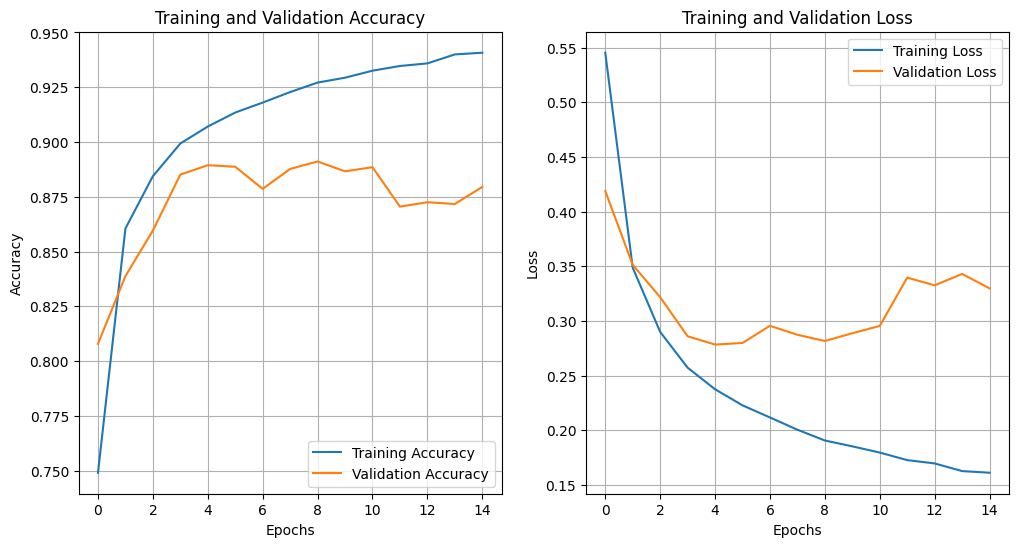

In [20]:
# Prompt: Plot the training and validation accuracy over epochs.
# Also, plot the training and validation loss over epochs.
# Use `matplotlib.pyplot` to visualize the 'history' object.

import matplotlib.pyplot as plt

# Get the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs) # 'epochs' variable from your training step

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.show()

Final Evaluation

In [21]:
# Prompt: Evaluate the trained model on the unseen `test_padded` data and `y_test` labels.
# Print the final test loss and test accuracy.

test_loss, test_accuracy = model.evaluate(test_padded, y_test, verbose=0)

print(f"\nFinal Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")


Final Test Loss: 0.3298
Final Test Accuracy: 0.8795


Live Predictions:

In [22]:
# Prompt: Create a function `predict_sentiment_live` that takes a raw text review string as input.
# This function should:
# 1. Preprocess the text using the `tokenizer` you fitted earlier (convert to sequence).
# 2. Pad the sequence to `max_len`.
# 3. Use the trained `model` to make a prediction.
# 4. Convert the prediction (a probability) into a 'Positive' or 'Negative' sentiment label.
# Test the function with at least one clearly positive and one clearly negative review.

def predict_sentiment_live(review_text):
    # 1. Preprocess the text: Tokenize and convert to sequence
    # Ensure the tokenizer is available in this scope
    # (It should be if you ran the previous cells in order)
    sequence = tokenizer.texts_to_sequences([review_text])

    # 2. Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # 3. Make prediction
    prediction = model.predict(padded_sequence)[0][0] # Get the single probability value

    # 4. Convert probability to label
    sentiment = "Positive" if prediction >= 0.5 else "Negative"
    return sentiment, prediction

# Test cases
print("\n--- Live Predictions ---")
review1 = "This movie was absolutely brilliant! I highly recommend it."
sentiment1, prob1 = predict_sentiment_live(review1)
print(f"Review: '{review1}'\nPredicted Sentiment: {sentiment1} (Probability: {prob1:.4f})")

review2 = "Worst film I have ever seen. A complete waste of time and money."
sentiment2, prob2 = predict_sentiment_live(review2)
print(f"Review: '{review2}'\nPredicted Sentiment: {sentiment2} (Probability: {prob2:.4f})")

review3 = "It was okay, not great, not terrible, just meh."
sentiment3, prob3 = predict_sentiment_live(review3)
print(f"Review: '{review3}'\nPredicted Sentiment: {sentiment3} (Probability: {prob3:.4f})")


--- Live Predictions ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Review: 'This movie was absolutely brilliant! I highly recommend it.'
Predicted Sentiment: Positive (Probability: 0.9651)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Review: 'Worst film I have ever seen. A complete waste of time and money.'
Predicted Sentiment: Negative (Probability: 0.0622)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Review: 'It was okay, not great, not terrible, just meh.'
Predicted Sentiment: Positive (Probability: 0.5235)
